Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

from model.modelcore import epid_model
from model.modelhelper import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


## Optimization Settings

In [3]:
start_time='2020-02-26'
end_time='2020-09-30'
observations=['Confirmed_cases', 'Admissions_hospital'] # ['Number_of_deaths', 'Confirmed_cases', 'Admissions_hospital']

dtype = torch.float32
device = torch.device("cuda:0") #cuda:0

## Initialize Observations

In [4]:
df_obs_initial = pd.read_csv('data/observations_03022022.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs = initialize_observations(df_obs_initial, start=start_time, end=end_time, observations=observations)
observed = torch.tensor(df_obs['Confirmed_cases'], requires_grad=False, device=device, dtype=dtype)
df_obs.head(3)

,Date,Confirmed_cases,Admissions_hospital
0,2020-02-26,1,0
1,2020-02-27,1,0
2,2020-02-28,1,0


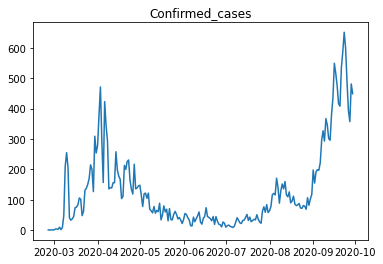

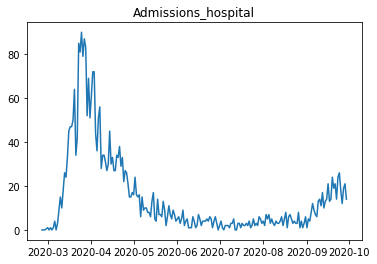

In [5]:
for observation in observations:
  plt.plot(df_obs['Date'], df_obs[observation])
  plt.title(observation)
  plt.show()

## Initialize Model Parameter

### Initialize Helper Parameter

In [6]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize to be optimized Model Parameter

In [7]:
parameter = ['R0', 'alpha', 'sigma']
dict_param = initialize_parameter(parameter, device=device, dtype=dtype)

In [8]:
epsilon_t = initialize_epsilon(num_observations, dict_param['real_values']['sigma'], dtype=dtype, device=device)

# Optimization

## Training

Step: 0, Time: 1.096482515335083, Loss: 20110.00390625, Mean Expected Daily Hospit: 43.07914733886719


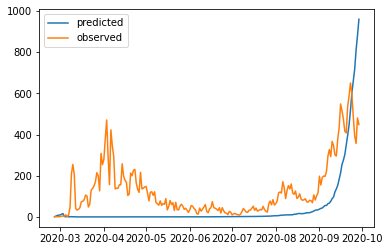

Step: 5, Time: 0.972050666809082, Loss: 19274.453125, Mean Expected Daily Hospit: 39.58782196044922
Step: 10, Time: 1.0624585151672363, Loss: 18996.921875, Mean Expected Daily Hospit: 33.71226119995117
Step: 15, Time: 0.9954066276550293, Loss: 18570.072265625, Mean Expected Daily Hospit: 41.109466552734375
Step: 20, Time: 0.41701459884643555, Loss: 18171.611328125, Mean Expected Daily Hospit: 36.98819351196289
Step: 25, Time: 0.39932727813720703, Loss: 17752.34375, Mean Expected Daily Hospit: 42.40421676635742
Step: 30, Time: 0.41547560691833496, Loss: 17324.7734375, Mean Expected Daily Hospit: 40.01375198364258
Step: 35, Time: 0.40952205657958984, Loss: 16877.18359375, Mean Expected Daily Hospit: 44.177791595458984
Step: 40, Time: 0.4201502799987793, Loss: 16416.08203125, Mean Expected Daily Hospit: 43.51683807373047
Step: 45, Time: 0.4362044334411621, Loss: 15944.2294921875, Mean Expected Daily Hospit: 45.89857864379883
Step: 50, Time: 0.44434690475463867, Loss: 15468.201171875, Mean

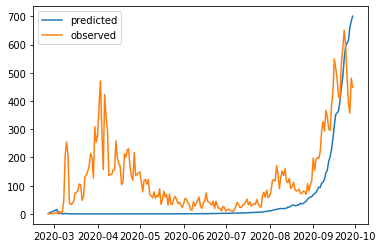

Step: 55, Time: 0.4030427932739258, Loss: 14986.8603515625, Mean Expected Daily Hospit: 48.42267608642578
Step: 60, Time: 0.38704466819763184, Loss: 14502.5009765625, Mean Expected Daily Hospit: 50.96321487426758
Step: 65, Time: 0.3863253593444824, Loss: 14027.689453125, Mean Expected Daily Hospit: 52.61320877075195
Step: 70, Time: 0.3816404342651367, Loss: 13571.572265625, Mean Expected Daily Hospit: 54.10606002807617
Step: 75, Time: 0.3998439311981201, Loss: 13142.837890625, Mean Expected Daily Hospit: 56.338035583496094
Step: 80, Time: 0.3996543884277344, Loss: 12754.21875, Mean Expected Daily Hospit: 58.38856887817383
Step: 85, Time: 0.40113019943237305, Loss: 12414.6171875, Mean Expected Daily Hospit: 60.083370208740234
Step: 90, Time: 0.3888862133026123, Loss: 12131.6005859375, Mean Expected Daily Hospit: 61.857730865478516
Step: 95, Time: 0.39960193634033203, Loss: 11907.076171875, Mean Expected Daily Hospit: 63.67909240722656
Step: 100, Time: 0.397968053817749, Loss: 11737.5136

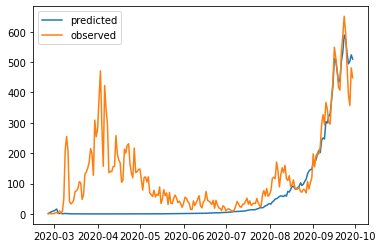

Step: 105, Time: 0.39194321632385254, Loss: 11613.4921875, Mean Expected Daily Hospit: 66.55669403076172
Step: 110, Time: 0.3989083766937256, Loss: 11522.5380859375, Mean Expected Daily Hospit: 67.6219482421875
Step: 115, Time: 0.40026187896728516, Loss: 11452.1826171875, Mean Expected Daily Hospit: 68.5195541381836
Step: 120, Time: 0.40283703804016113, Loss: 11392.982421875, Mean Expected Daily Hospit: 69.2410659790039
Step: 125, Time: 0.39882731437683105, Loss: 11339.6025390625, Mean Expected Daily Hospit: 69.78145599365234
Step: 130, Time: 0.40128660202026367, Loss: 11290.0576171875, Mean Expected Daily Hospit: 70.17413330078125


In [ ]:
epochs = 1000

params_to_be_optimized = [epsilon_t]
for param in parameter:
  params_to_be_optimized.append(dict_param['prime_values'][param])

optimizer = optim.Adam(params_to_be_optimized, lr=0.01, weight_decay=1e-8)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # forward pass
  transform_prime_variables(dict_param)
  expected = epid_model(population, R=torch.abs(epsilon_t), initial_newly_infected=np.arange(1, 18, 3), alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

  # calc loss
  comparison_loss = calc_mse(expected, observed)
  prior_loss = calc_prior_loss(dict_param, device=device, dtype=dtype)
  loss = comparison_loss + prior_loss

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 5==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')
  
  if i % 50==0:
    plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
    plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
    plt.legend()
    plt.show()


# Evaluation

In [ ]:
plt.plot(df_obs['Date'], observed.cpu().detach().numpy())
plt.title('observed')
plt.show()

In [ ]:
plt.plot(df_obs['Date'], expected.cpu().detach().numpy())
plt.title('expected')
plt.show()